## Config Information

In [1]:
import json
credentials = "Credentials.json"
with open(credentials) as f:
    db_conn_dict = json.load(f)

schema_name = "sydney_analysis"
SRID=4283

# 121	Sydney - North Sydney and Hornsby
# 125	Sydney - Parramatta
# 119   Sydney - Inner South West
area1=121
area2=125
area3=119

sa2_tmp=102011028
#sa4_tmp=102

## Task 1
#### Set up
#### Connection to PostgreSQL

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from sqlalchemy import create_engine, text
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
import requests
import folium
import time

def pgconnect():
    db_conn_dict
    host       = db_conn_dict['host']
    db_user    = db_conn_dict['user']
    db_pw      = db_conn_dict['password']
    default_db = db_conn_dict['db']
    port       = db_conn_dict['port']
    try:
        db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
        conn = db.connect()
        print('Connected successfully.')
    except Exception as e:
        print("Unable to connect to the database.")
        print(e)
        db, conn = None, None
    return db,conn
    
db, conn = pgconnect()

conn.execute(text("CREATE EXTENSION IF NOT EXISTS postgis"))
print("✅ PostGIS Extension Enabled")

Connected successfully.
✅ PostGIS Extension Enabled


#### Create New Schema and Creating Table Structures

In [3]:
#create schema
conn.execute(text(f"DROP SCHEMA IF EXISTS {schema_name} CASCADE"))
print(f"✅ Schema '{schema_name}' and all its objects have been dropped.")
conn.execute(text(f"CREATE SCHEMA IF NOT EXISTS {schema_name}"))
print(f"✅ New Project schema '{schema_name}' is created")

#set search_path of schema
conn.execute(text(f"SET search_path TO {schema_name}, public"))

#set PostGIS
result = conn.execute(text("SELECT PostGIS_Version();"))
postgis_version = result.scalar()
print(f"✅ PostGIS Version: {postgis_version}")

#create tables
create_table_sql = f"""
DROP TABLE IF EXISTS sa2_regions;
CREATE TABLE IF NOT EXISTS sa2_regions (
    "SA2_CODE21"   INTEGER NOT NULL PRIMARY KEY,
    "SA2_NAME21"   VARCHAR NOT NULL,
    "CHG_FLAG21"   INTEGER NOT NULL,
    "CHG_LBL21"    VARCHAR NOT NULL,
    "SA3_CODE21"   INTEGER NOT NULL,
    "SA3_NAME21"   VARCHAR NOT NULL,
    "SA4_CODE21"   INTEGER NOT NULL,
    "SA4_NAME21"   VARCHAR NOT NULL,
    "GCC_CODE21"   VARCHAR NOT NULL,
    "GCC_NAME21"   VARCHAR NOT NULL,
    "STE_CODE21"   INTEGER NOT NULL,
    "STE_NAME21"   VARCHAR NOT NULL,
    "AUS_CODE21"   VARCHAR NOT NULL,
    "AUS_NAME21"   VARCHAR NOT NULL,
    "AREASQKM21"   DOUBLE PRECISION NOT NULL,
    "LOCI_URI21"   VARCHAR NOT NULL,
    "geometry"     GEOMETRY(MULTIPOLYGON, {SRID}) NOT NULL
);
""" # 17 columns
conn.execute(text(create_table_sql))
print("✅ Table 'sa2_regions' is created")

create_table_sql = f"""
DROP TABLE IF EXISTS businesses;
CREATE TABLE IF NOT EXISTS businesses (
    "industry_code"            VARCHAR NOT NULL,
    "industry_name"            VARCHAR NOT NULL,
    sa2_code21                 INTEGER NOT NULL,
    "sa2_name"                 VARCHAR NOT NULL, 
    "0_to_50k_businesses"      INTEGER NOT NULL,
    "50k_to_200k_businesses"   INTEGER NOT NULL,
    "200k_to_2m_businesses"    INTEGER NOT NULL,
    "2m_to_5m_businesses"      INTEGER NOT NULL,
    "5m_to_10m_businesses"     INTEGER NOT NULL,
    "10m_or_more_businesses"   INTEGER NOT NULL,
    "total_businesses"         INTEGER NOT NULL,
    PRIMARY KEY ("industry_code", "sa2_code21"),
    FOREIGN KEY (sa2_code21) REFERENCES sa2_regions("SA2_CODE21")
);
"""
conn.execute(text(create_table_sql))
print("✅ Table 'businesses' is created")

create_table_sql = f"""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    "stop_id"              VARCHAR NOT NULL PRIMARY KEY,
    "stop_code"            INTEGER,
    "stop_name"            VARCHAR NOT NULL,
    sa2_code21             INTEGER NOT NULL,
    "location_type"        INTEGER,
    "parent_station"       VARCHAR,
    "wheelchair_boarding"  INTEGER NOT NULL,
    "platform_code"        VARCHAR,
    "geometry"             geometry(POINT, {SRID}) NOT NULL,
    FOREIGN KEY (sa2_code21) REFERENCES sa2_regions("SA2_CODE21")
);
"""
conn.execute(text(create_table_sql))
print("✅ Table 'stops' is created")

create_table_sql = f"""
DROP TABLE IF EXISTS schools;
CREATE TABLE schools (
    "USE_ID"                INTEGER NOT NULL,
    "CATCH_TYPE"            VARCHAR NOT NULL,
    "USE_DESC"              VARCHAR NOT NULL,
    "ADD_DATE"              DATE,
    "KINDERGART"            BOOLEAN NOT NULL,
    "YEAR1"                 BOOLEAN NOT NULL,
    "YEAR2"                 BOOLEAN NOT NULL,
    "YEAR3"                 BOOLEAN NOT NULL,
    "YEAR4"                 BOOLEAN NOT NULL,
    "YEAR5"                 BOOLEAN NOT NULL,
    "YEAR6"                 BOOLEAN NOT NULL,
    "YEAR7"                 BOOLEAN NOT NULL,
    "YEAR8"                 BOOLEAN NOT NULL,
    "YEAR9"                 BOOLEAN NOT NULL,
    "YEAR10"                BOOLEAN NOT NULL,
    "YEAR11"                BOOLEAN NOT NULL,
    "YEAR12"                BOOLEAN NOT NULL,
    "PRIORITY"              BOOLEAN,
    "geometry"              geometry(MULTIPOLYGON, {SRID}) NOT NULL,
    "current_enrolment_year" INTEGER NOT NULL,
    sa2_code21              INTEGER NOT NULL,
    PRIMARY KEY ("USE_ID", "CATCH_TYPE"),
    FOREIGN KEY (sa2_code21) REFERENCES sa2_regions("SA2_CODE21")
);
"""
conn.execute(text(create_table_sql))
print("✅ Table 'schools' is created")

create_table_sql = f"""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code21     INTEGER NOT NULL PRIMARY KEY,
    "sa2_name"     VARCHAR NOT NULL,
    "0-4_people"   INTEGER NOT NULL,
    "5-9_people"   INTEGER NOT NULL,
    "10-14_people" INTEGER NOT NULL,
    "15-19_people" INTEGER NOT NULL,
    "20-24_people" INTEGER NOT NULL,
    "25-29_people" INTEGER NOT NULL,
    "30-34_people" INTEGER NOT NULL,
    "35-39_people" INTEGER NOT NULL,
    "40-44_people" INTEGER NOT NULL,
    "45-49_people" INTEGER NOT NULL,
    "50-54_people" INTEGER NOT NULL,
    "55-59_people" INTEGER NOT NULL,
    "60-64_people" INTEGER NOT NULL,
    "65-69_people" INTEGER NOT NULL,
    "70-74_people" INTEGER NOT NULL,
    "75-79_people" INTEGER NOT NULL,
    "80-84_people" INTEGER NOT NULL,
    "85-and-over_people" INTEGER NOT NULL,
    "total_people" INTEGER NOT NULL,
    FOREIGN KEY (sa2_code21) REFERENCES sa2_regions("SA2_CODE21")
);
"""
conn.execute(text(create_table_sql))
print("✅ Table 'population' is created")

create_table_sql = f"""
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    "sa2_code21"     INTEGER NOT NULL PRIMARY KEY,
    "sa2_name"       VARCHAR NOT NULL,
    "earners"        INTEGER,
    "median_age"     INTEGER,
    "median_income"  INTEGER,
    "mean_income"    INTEGER,
    FOREIGN KEY (sa2_code21) REFERENCES sa2_regions("SA2_CODE21")
);
"""
conn.execute(text(create_table_sql))
print("✅ Table 'income' is created")

create_table_sql = f"""
DROP TABLE IF EXISTS poi;
CREATE TABLE poi (
    objectid      INTEGER PRIMARY KEY,
    sa2_code21    INTEGER NOT NULL,
    topoid INTEGER NOT NULL,
    poigroup INTEGER NOT NULL,
    poitype VARCHAR NOT NULL,
    poiname VARCHAR,
    poilabel VARCHAR NOT NULL,
    poilabeltype VARCHAR NOT NULL,
    poialtlabel VARCHAR,
    poisourcefeatureoid INTEGER NOT NULL,
    accesscontrol INTEGER NOT NULL,
    startdate DATE NOT NULL,
    enddate DATE NOT NULL,
    lastupdate DATE NOT NULL,
    msoid INTEGER NOT NULL,
    centroidid INTEGER,
    shapeuuid VARCHAR NOT NULL,
    changetype VARCHAR NOT NULL,
    processstate VARCHAR,
    urbanity VARCHAR NOT NULL,
    geometry geometry(Point, {SRID}) NOT NULL,
    FOREIGN KEY (sa2_code21) REFERENCES sa2_regions("SA2_CODE21")
);
"""
conn.execute(text(create_table_sql))
print("✅ Table 'poi' is created")

✅ Schema 'sydney_analysis' and all its objects have been dropped.
✅ New Project schema 'sydney_analysis' is created
✅ PostGIS Version: 3.5 USE_GEOS=1 USE_PROJ=1 USE_STATS=1
✅ Table 'sa2_regions' is created
✅ Table 'businesses' is created
✅ Table 'stops' is created
✅ Table 'schools' is created
✅ Table 'population' is created
✅ Table 'income' is created
✅ Table 'poi' is created


#### Loading and Testing all table

In [4]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

def loading_sa2_regions():
    #select Greater Sydney
    sa2_gdf = gpd.read_file("data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
    sa2_gdf = sa2_gdf[sa2_gdf['GCC_NAME21'] == 'Greater Sydney']
    #convert to Well Known
    sa2_gdf['geometry'] = sa2_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=SRID))
    for col in ['SA2_CODE21', 'CHG_FLAG21', 'SA3_CODE21', 'SA4_CODE21', 'STE_CODE21']:
        sa2_gdf[col] = sa2_gdf[col].astype(int)
    sa2_gdf.to_sql("sa2_regions", conn, 
                   if_exists='append', index=False, 
                   dtype={'geometry': Geometry('MULTIPOLYGON', SRID)})

loading_sa2_regions()
existing_sa2_codes = pd.read_sql('SELECT "SA2_CODE21" FROM sa2_regions', conn)
existing_sa2_code_set = set(existing_sa2_codes['SA2_CODE21'])

def loading_businesses():
    business_df = pd.read_csv("data/Businesses.csv")
    business_df = business_df[business_df['sa2_code'].isin(existing_sa2_code_set)]
    business_df = business_df.rename(columns={'sa2_code': 'sa2_code21'})
    business_df.to_sql("businesses", conn, if_exists="append", index=False)

loading_businesses()

def loading_stops():
    stops_df = pd.read_csv("data/Stops.txt")
    stops_df['geometry'] = gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat)
    stops_df = stops_df.drop(columns=['stop_lon', 'stop_lat'])
    stops_df['geometry'] = stops_df['geometry'].apply(lambda x: WKTElement(x.wkt, srid=SRID))
    stops_df['sa2_code21'] = sa2_tmp
    stops_df.to_sql('stops', conn, if_exists='append', 
                    index=False, dtype={'geometry': Geometry('POINT', SRID)})

loading_stops()

def loading_schools():
    primary_gdf = gpd.read_file("data/catchments/catchments_primary.shp")
    secondary_gdf = gpd.read_file("data/catchments/catchments_secondary.shp")
    future_gdf = gpd.read_file("data/catchments/catchments_future.shp")
    school_gdf = pd.concat([primary_gdf, secondary_gdf, future_gdf], ignore_index=True)
    school_gdf['current_enrolment_year'] = 2023
    school_gdf['sa2_code21'] = sa2_tmp

    #convert to Well Known
    school_gdf['geometry'] = school_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=SRID))  # applying the function
    school_gdf = school_gdf.drop_duplicates(subset=["USE_ID", "CATCH_TYPE"], keep="first")
    bool_column= ["KINDERGART", "PRIORITY"] + [f"YEAR{i}" for i in range(1, 13)]
    for col in bool_column:
        school_gdf[col] = school_gdf[col].map({"Y": True, "N": False, "None": pd.NA})

    school_gdf.to_sql("schools", conn, 
                    if_exists='append', index=False, 
                    dtype={'geometry': Geometry('MULTIPOLYGON', SRID)})

loading_schools()

def loading_population():
    population_df = pd.read_csv("data/Population.csv")
    population_df = population_df.rename(columns={'sa2_code': 'sa2_code21'})
    population_df.to_sql("population", conn, if_exists="append", index=False)

loading_population()

def loading_income():
    income_df = pd.read_csv("data/Income.csv")
    income_df.replace('np', pd.NA, inplace=True)
    income_df = income_df[income_df['sa2_code21'].isin(existing_sa2_code_set)]
    income_df.to_sql("income", conn, if_exists="append", index=False)

loading_income()

def query(conn, sqlcmd, geom_name=None, args=None, df=True, update=False):
    result = pd.DataFrame() if df else None
    try:
        if df:
            if geom_name:
                result = gpd.read_postgis(sqlcmd, conn, geom_col=geom_name)
            else:
                result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        if not update:
            print("Error encountered: ", e, sep='\n')
    return result

#display(query(conn, "select * from sa2_regions"))
#display(query(conn, "select * from businesses"))
#display(query(conn, "select * from stops"))
#display(query(conn, "select * from schools"))
#display(query(conn, "select * from population"))
#display(query(conn, "select * from income"))

C:\Users\liuha\AppData\Local\Temp\ipykernel_22356\2721394835.py:11: UserWarning: Geometry column does not contain geometry.
  sa2_gdf['geometry'] = sa2_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=SRID))
C:\Users\liuha\AppData\Local\Temp\ipykernel_22356\2721394835.py:50: UserWarning: Geometry column does not contain geometry.
  school_gdf['geometry'] = school_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=SRID))  # applying the function


## Task 2

#### API Query and POI loading

In [5]:
def fetch_pois_for_bbox(xmin, ymin, xmax, ymax):
    url = "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query"
    params = {
        "where":        "1=1",
        "outFields":    "*",
        "geometry":     f"{xmin},{ymin},{xmax},{ymax}",
        "geometryType": "esriGeometryEnvelope",
        "inSR":         f"{SRID}",
        "outSR":        f"{SRID}",
        "f":            "json",
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json().get("features", [])
    rows = []
    for feat in data:
        attr = feat["attributes"]
        x, y = feat["geometry"]["x"], feat["geometry"]["y"]
        rows.append({**attr, "lon": x, "lat": y})
    return pd.DataFrame(rows)

from datetime import datetime
def convert_timestamp_ms_to_date(ts):
    try:
        return datetime.fromtimestamp(ts / 1000).date()
    except:
        return None

def loading_poi():
    sql = f"""
    SELECT 
        "SA2_CODE21" as sa2_code21,
        ST_XMin(geometry) AS xmin,
        ST_YMin(geometry) AS ymin,
        ST_XMax(geometry) AS xmax,
        ST_YMax(geometry) AS ymax
    FROM sa2_regions
    WHERE "SA4_CODE21" IN ({area1}, {area2}, {area3});
    """
    sa2_df = query(conn, sql)
    all_pois = []
    for idx, sa2 in sa2_df.iterrows():
        df = fetch_pois_for_bbox(sa2.xmin, sa2.ymin, sa2.xmax, sa2.ymax)
        if not df.empty:
            all_pois.append(df)
        time.sleep(1)

    poi_df = pd.concat(all_pois, ignore_index=True)
    poi_df['geometry'] = gpd.points_from_xy(poi_df.lon, poi_df.lat)
    poi_df['sa2_code21'] = sa2_tmp
    poi_df = poi_df.drop(columns=['lon', 'lat'])
    poi_df['geometry'] = poi_df['geometry'].apply(lambda x: WKTElement(x.wkt, srid=SRID))

    for col in ['startdate', 'enddate', 'lastupdate']:
        poi_df[col] = poi_df[col].apply(convert_timestamp_ms_to_date)

    poi_df = poi_df.drop_duplicates()

    poi_df.to_sql('poi', conn, if_exists='append', 
                    index=False, dtype={'geometry': Geometry('POINT', SRID)})

loading_poi()

#### Create Index

In [6]:
#sa2_regions index
sql=f"""
CREATE INDEX sa2_regions_geom_idx 
ON sa2_regions 
USING GIST (geometry);
"""
query(conn, sql, update=True)
sql=f"""
CREATE INDEX sa2_regions_idx 
ON sa2_regions ("SA4_CODE21")
"""
query(conn, sql, update=True)

#stops
sql=f"""
UPDATE stops st
SET sa2_code21 = s."SA2_CODE21"
FROM sa2_regions s
WHERE ST_Within(st.geometry, s.geometry) AND s."SA4_CODE21" IN ({area1}, {area2}, {area3});
"""
query(conn, sql, update=True)
sql=f"""
DELETE FROM stops
WHERE sa2_code21 = {sa2_tmp};
"""
query(conn, sql, update=True)

#schools
sql=f"""
UPDATE schools sc
SET sa2_code21 = s."SA2_CODE21"
FROM sa2_regions s
WHERE ST_Area(ST_Intersection(sc.geometry, s.geometry))>ST_Area(sc.geometry)/2 AND s."SA4_CODE21" IN ({area1}, {area2}, {area3});
"""
query(conn, sql, update=True)
sql=f"""
DELETE FROM schools
WHERE sa2_code21 = {sa2_tmp};
"""
query(conn, sql, update=True)

#poi
sql=f"""
UPDATE poi p
SET sa2_code21 = s."SA2_CODE21"
FROM sa2_regions s
WHERE ST_Within(p.geometry, s.geometry) AND s."SA4_CODE21" IN ({area1}, {area2}, {area3});
"""
query(conn, sql, update=True)
sql=f"""
DELETE FROM poi
WHERE sa2_code21 = {sa2_tmp};
"""
query(conn, sql, update=True)


#other table index
sql=f"""
CREATE INDEX businesses_idx 
ON businesses (sa2_code21)
"""
query(conn, sql, update=True)
sql=f"""
CREATE INDEX stops_idx 
ON stops (sa2_code21)
"""
query(conn, sql, update=True)
sql=f"""
CREATE INDEX schools_idx 
ON schools (sa2_code21)
"""
query(conn, sql, update=True)
sql=f"""
CREATE INDEX population_idx 
ON population (sa2_code21)
"""
query(conn, sql, update=True)
sql=f"""
CREATE INDEX income_idx 
ON income (sa2_code21)
"""
query(conn, sql, update=True)
sql=f"""
CREATE INDEX poi_idx 
ON poi (sa2_code21)
"""
query(conn, sql, update=True)

""


## Task 3

#### Business Per Capita


In [7]:
sql_business = f"""
WITH valid_regions AS (
    SELECT sa2_code21
    FROM population
    WHERE total_people >= 100
),

business_values AS (
    SELECT
        r."SA2_CODE21" AS sa2_code21,
        (
            25 * COALESCE(b."0_to_50k_businesses", 0) +
            125 * COALESCE(b."50k_to_200k_businesses", 0) +
            1100 * COALESCE(b."200k_to_2m_businesses", 0) +
            3500 * COALESCE(b."2m_to_5m_businesses", 0) +
            7500 * COALESCE(b."5m_to_10m_businesses", 0) +
            12000 * COALESCE(b."10m_or_more_businesses", 0)
        ) AS estimated_value
    FROM sa2_regions r
    JOIN valid_regions vr ON r."SA2_CODE21" = vr.sa2_code21
    LEFT JOIN businesses b ON r."SA2_CODE21" = b.sa2_code21
    WHERE r."SA4_CODE21" IN ({area1}, {area2}, {area3}) and b.industry_code in ('D','G','H','I','J','K','L','N','O','P','Q')
),

per_capita_value AS (
    SELECT
        bv.sa2_code21,
        COALESCE(bv.estimated_value::FLOAT / NULLIF(p.total_people, 0), 0) AS per_capita_score
    FROM business_values bv
    JOIN population p ON bv.sa2_code21 = p.sa2_code21
),

sa2_score AS (
    SELECT
        sa2_code21,
        SUM(per_capita_score) AS raw_score
    FROM per_capita_value
    GROUP BY sa2_code21
),

stats AS (
    SELECT
        AVG(raw_score) AS mean,
        STDDEV_POP(raw_score) AS std
    FROM sa2_score
)

SELECT
    s.sa2_code21,
    r."SA4_CODE21",
    s.raw_score,
    (s.raw_score - st.mean) / NULLIF(st.std, 0) AS z_score
FROM sa2_score s
JOIN sa2_regions r ON s.sa2_code21 = r."SA2_CODE21"
CROSS JOIN stats st
"""
df=query(conn, sql_business)
#display(df)

In [8]:
df.sort_values('z_score', ascending=False).head(10)

,sa2_code21,SA4_CODE21,raw_score,z_score
64,121041417,121,502.234059,7.488473
1,119011355,119,302.652027,4.192478
42,121011401,121,186.079593,2.267344
95,125041717,125,172.775137,2.047628
45,121011684,121,141.279717,1.527497
73,125011709,125,120.228149,1.179842
2,119011356,119,111.277843,1.032032
63,121041416,121,81.806124,0.545322
27,119031664,119,74.713827,0.428196
21,119021663,119,69.797319,0.347002


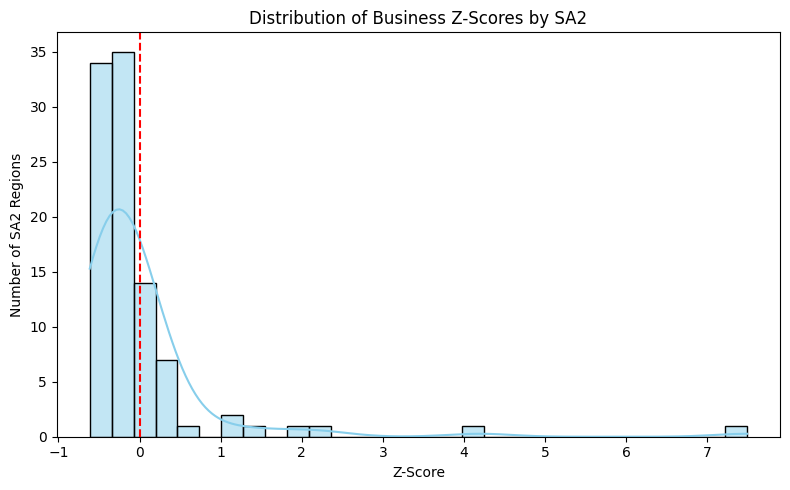

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(df['z_score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Business Z-Scores by SA2')
plt.xlabel('Z-Score')
plt.ylabel('Number of SA2 Regions')
plt.axvline(0, color='red', linestyle='--') 
plt.tight_layout()
plt.show()

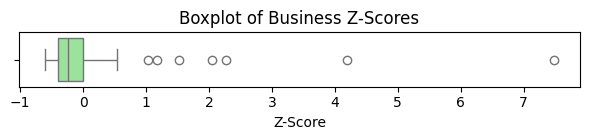

In [10]:
plt.figure(figsize=(6, 1.5))
sns.boxplot(x=df['z_score'], color='lightgreen')
plt.title('Boxplot of Business Z-Scores')
plt.xlabel('Z-Score')
plt.tight_layout()
plt.show()

#### Stops

In [11]:
sql_stops = f"""
WITH valid_regions AS (
    SELECT sa2_code21
    FROM population
    WHERE total_people >= 100
),

stop_counts AS (
    SELECT
        r."SA2_CODE21" AS sa2_code21,
        COUNT(s.stop_id) AS num_stops
    FROM sa2_regions r
    JOIN valid_regions vr ON r."SA2_CODE21" = vr.sa2_code21
    LEFT JOIN stops s ON r."SA2_CODE21" = s.sa2_code21
    WHERE r."SA4_CODE21" IN ({area1}, {area2}, {area3})
    GROUP BY r."SA2_CODE21"
),

stats AS (
    SELECT
        AVG(num_stops) AS mean_val,
        STDDEV_POP(num_stops) AS std_val
    FROM stop_counts
)

SELECT
    sc.sa2_code21,
    r."SA4_CODE21",
    sc.num_stops,
    (sc.num_stops - st.mean_val) / NULLIF(st.std_val, 0) AS z_score
FROM stop_counts sc
JOIN sa2_regions r ON sc.sa2_code21 = r."SA2_CODE21"
CROSS JOIN stats st
"""
df=query(conn, sql_stops)
#display(df)

In [12]:
df_stops = query(conn, sql_stops)  # Make sure this uses the stop-related SQL
df_stops.sort_values('z_score', ascending=False).head(10)

,sa2_code21,SA4_CODE21,num_stops,z_score
49,121021403,121,368,2.819419
0,119011354,119,352,2.608712
56,121031408,121,330,2.318989
51,121021406,121,308,2.029267
75,125021477,125,294,1.844898
57,121031409,121,283,1.700037
59,121031411,121,273,1.568345
24,119031372,119,267,1.489330
83,125031484,125,262,1.423483
58,121031410,121,256,1.344468


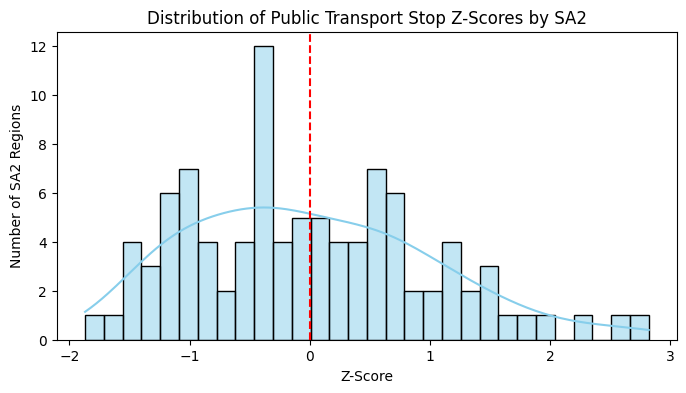

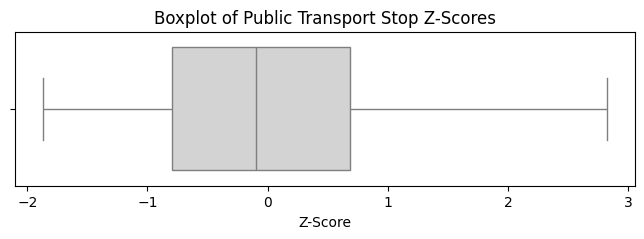

In [13]:
# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(df_stops["z_score"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.axvline(df_stops["z_score"].mean(), color='red', linestyle='--')
plt.title("Distribution of Public Transport Stop Z-Scores by SA2")
plt.xlabel("Z-Score")
plt.ylabel("Number of SA2 Regions")
plt.show()

# Boxplot
plt.figure(figsize=(8, 2))
sns.boxplot(x=df_stops["z_score"], color='lightgrey')
plt.title("Boxplot of Public Transport Stop Z-Scores")
plt.xlabel("Z-Score")
plt.show()

#### School

In [14]:
sql_schools=f"""
WITH valid_sa2 AS (
    SELECT sa2_code21
    FROM population p
    join sa2_regions r on r."SA2_CODE21" = p.sa2_code21
    WHERE total_people >= 100 and r."SA4_CODE21" IN ({area1}, {area2}, {area3})
),

young_population AS (
    SELECT
        sa2_code21,
        "5-9_people" + "10-14_people" + "15-19_people" AS young_people
    FROM population
),

school_counts AS (
    SELECT
        r."SA2_CODE21" AS sa2_code21,
        COUNT(s.*) AS school_count
    FROM sa2_regions r
    JOIN valid_sa2 v ON r."SA2_CODE21" = v.sa2_code21
    LEFT JOIN schools s ON r."SA2_CODE21" = s.sa2_code21
    WHERE r."SA4_CODE21" IN ({area1}, {area2}, {area3})
    GROUP BY r."SA2_CODE21"
),

per_capita_school AS (
    SELECT
        r."SA2_CODE21" AS sa2_code21,
        COALESCE(sc.school_count, 0)::FLOAT / NULLIF(COALESCE(yp.young_people, 0), 0) * 1000 AS schools_per_1000_youth
    FROM sa2_regions r
    JOIN valid_sa2 v ON r."SA2_CODE21" = v.sa2_code21
    LEFT JOIN school_counts sc ON r."SA2_CODE21" = sc.sa2_code21
    LEFT JOIN young_population yp ON r."SA2_CODE21" = yp.sa2_code21
),

stats AS (
    SELECT
        AVG(schools_per_1000_youth) AS mean_val,
        STDDEV_POP(schools_per_1000_youth) AS std_val
    FROM per_capita_school
)

SELECT
    pcs.sa2_code21,
    r."SA4_CODE21",
    pcs.schools_per_1000_youth,
    (pcs.schools_per_1000_youth - s.mean_val) / NULLIF(s.std_val, 0) AS z_score
FROM per_capita_school pcs
JOIN sa2_regions r ON pcs.sa2_code21 = r."SA2_CODE21"
JOIN valid_sa2 v ON r."SA2_CODE21" = v.sa2_code21
CROSS JOIN stats s
"""
df=query(conn, sql_schools)
#display(df)

In [15]:
df_schools = query(conn, sql_schools) 
df_schools.sort_values('z_score', ascending=False).head(10)

,sa2_code21,SA4_CODE21,schools_per_1000_youth,z_score
50,121021404,121,2.244669,3.990449
23,119031371,119,1.694915,2.659198
80,125031480,125,1.575796,2.370745
31,119041377,119,1.316945,1.743927
2,119011356,119,1.308901,1.724447
74,125011710,125,1.300390,1.703839
37,119041668,119,1.200480,1.461903
11,119011658,119,1.197963,1.455809
25,119031373,119,1.145475,1.328707
75,125021477,125,1.123848,1.276335


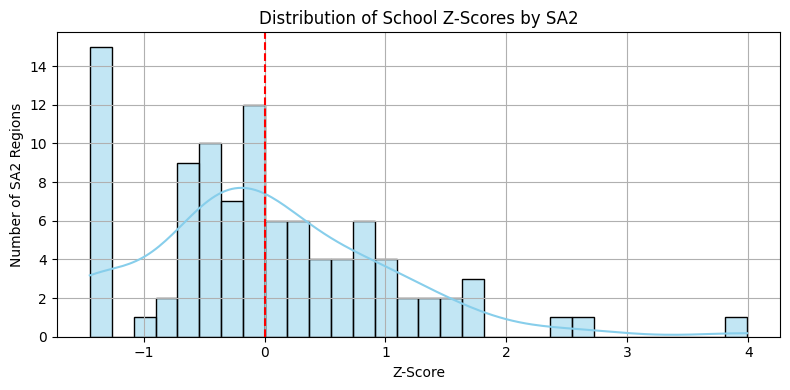

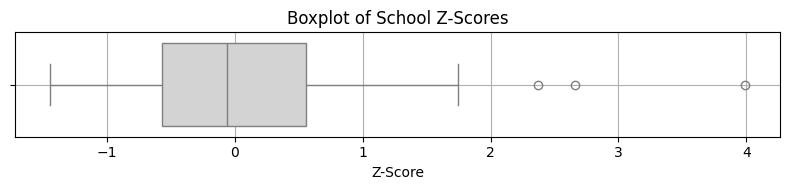

In [16]:
# Histogram of School Z-Scores
plt.figure(figsize=(8, 4))
sns.histplot(df_schools["z_score"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.axvline(df_schools["z_score"].mean(), color='red', linestyle='--')
plt.title("Distribution of School Z-Scores by SA2")
plt.xlabel("Z-Score")
plt.ylabel("Number of SA2 Regions")
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of School Z-Scores
plt.figure(figsize=(8, 2))
sns.boxplot(x=df_schools["z_score"], color='lightgray')
plt.title("Boxplot of School Z-Scores")
plt.xlabel("Z-Score")
plt.grid(True)
plt.tight_layout()
plt.show()

#### POIs

In [17]:
sql_poi=f"""
WITH filtered_poi AS (
  SELECT *
  FROM poi
  WHERE poigroup BETWEEN 1 AND 5
),


valid_regions AS (
  SELECT sa2_code21
  FROM population
  WHERE total_people >= 100
),

poi_counts AS (
  SELECT
    fp.sa2_code21,
    fp.poigroup,
    COUNT(*) AS count
  FROM filtered_poi fp
  JOIN valid_regions vr ON fp.sa2_code21 = vr.sa2_code21
  join sa2_regions s on vr.sa2_code21=s."SA2_CODE21"
  GROUP BY fp.sa2_code21, fp.poigroup, s."AREASQKM21"
),

group_stats AS (
  SELECT
    poigroup,
    AVG(count) AS mean,
    STDDEV_POP(count) AS std
  FROM poi_counts
  GROUP BY poigroup
),

z_scores AS (
  SELECT
    pc.sa2_code21,
    pc.poigroup,
    (pc.count - gs.mean) / NULLIF(gs.std, 0) AS z_score
  FROM poi_counts pc
  JOIN group_stats gs ON pc.poigroup = gs.poigroup
),

total_z_scores AS (
  SELECT
    sa2_code21,
    SUM(z_score) AS total_z_score
  FROM z_scores
  GROUP BY sa2_code21
)

SELECT
  t.sa2_code21,
  r."SA2_NAME21",
  r."SA4_CODE21",
  t.total_z_score
FROM total_z_scores t
JOIN sa2_regions r ON t.sa2_code21 = r."SA2_CODE21"
ORDER BY t.total_z_score DESC
"""
#display(query(conn, sql_poi))

In [18]:
df_pois = query(conn, sql_poi) 
df_pois.sort_values('total_z_score', ascending=False).head(10)

,sa2_code21,SA2_NAME21,SA4_CODE21,total_z_score
0,121031408,Lindfield - Roseville,121,8.758677
1,119041668,Arncliffe - Bardwell Valley,119,7.619885
2,121021404,Berowra - Brooklyn - Cowan,121,5.808477
3,125041489,North Parramatta,125,5.515574
4,119011354,Bass Hill - Georges Hall,119,5.343912
5,119031374,South Hurstville - Blakehurst,119,5.230354
6,121031412,Wahroonga (East) - Warrawee,121,5.122821
7,119041382,Sans Souci - Ramsgate,119,4.755406
8,119041377,Kingsgrove (South) - Bardwell Park,119,4.717175
9,121041417,North Sydney - Lavender Bay,121,4.062721


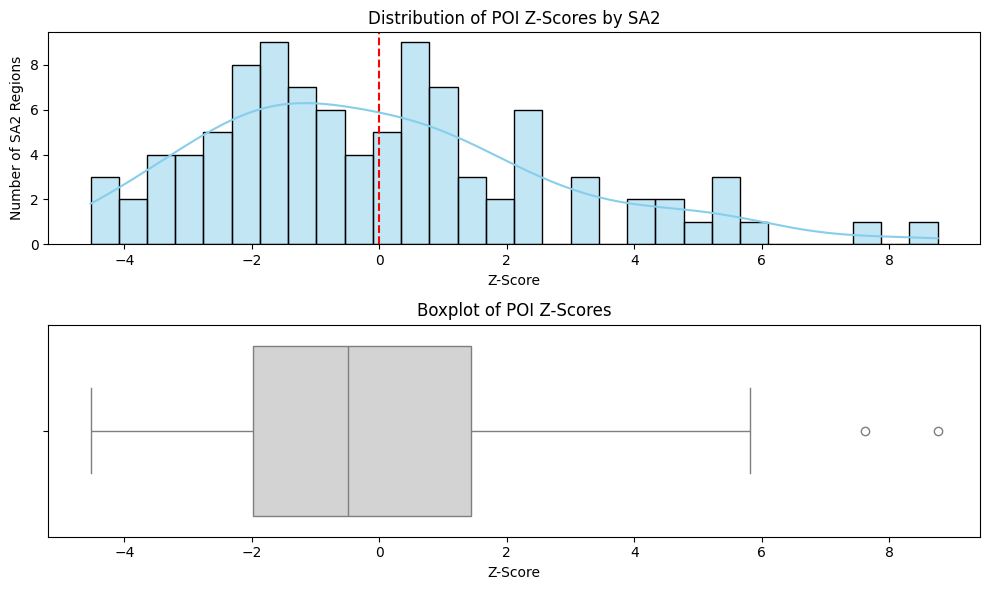

In [19]:
plt.figure(figsize=(10, 6))

# Histogram
plt.subplot(2, 1, 1)
sns.histplot(df_pois["total_z_score"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.axvline(df_pois["total_z_score"].mean(), color='red', linestyle='--')
plt.title("Distribution of POI Z-Scores by SA2")
plt.xlabel("Z-Score")
plt.ylabel("Number of SA2 Regions")

# Boxplot
plt.subplot(2, 1, 2)
sns.boxplot(x=df_pois["total_z_score"], color='lightgray')
plt.title("Boxplot of POI Z-Scores")
plt.xlabel("Z-Score")

plt.tight_layout()
plt.show()

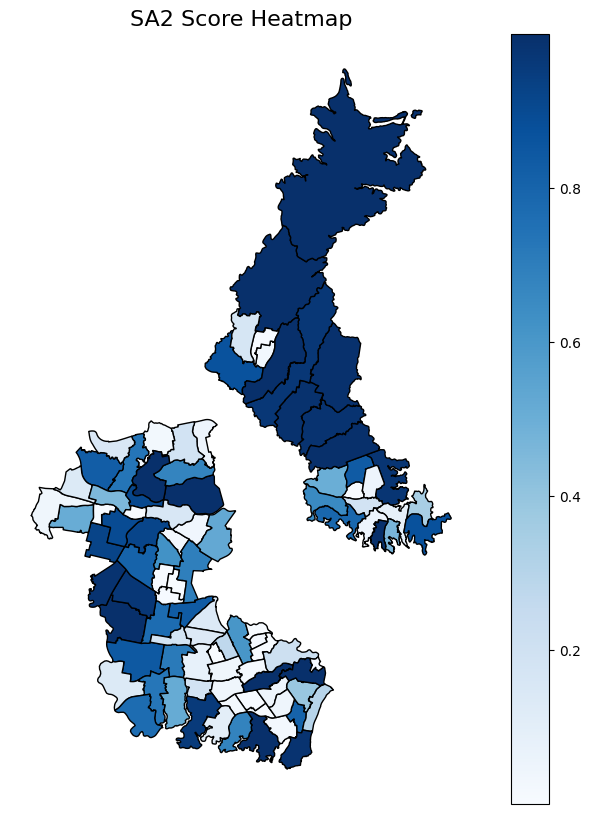

In [20]:

df_business = query(conn, sql_business)
df_stops = query(conn, sql_stops)
df_schools = query(conn, sql_schools)
df_poi = query(conn, sql_poi)

df_business = df_business.rename(columns={"z_score": "z_business"})
df_stops = df_stops.rename(columns={"z_score": "z_stops"})
df_schools = df_schools.rename(columns={"z_score": "z_schools"})
df_poi = df_poi.rename(columns={"total_z_score": "z_poi"})


df_merged = df_business.merge(df_stops, on=["sa2_code21", "SA4_CODE21"])
df_merged = df_merged.merge(df_schools, on=["sa2_code21", "SA4_CODE21"])
df_merged = df_merged.merge(df_poi, on=["sa2_code21", "SA4_CODE21"])

df_merged["score"] = 1 / (1 + np.exp(-(
    (df_merged["z_business"]
     + df_merged["z_stops"]
     + df_merged["z_schools"]
     + df_merged["z_poi"])
)))

df_merged = df_merged.sort_values(by="score", ascending=False)

sql= f"""
SELECT "SA2_CODE21", "SA2_NAME21"
FROM sa2_regions
"""
"""
df = query(conn, sql)
df = df.rename(columns={"SA2_CODE21": "sa2_code21"})
#df_merged = df_merged.merge(df, on=["sa2_code21"])
display(df_merged)
display(df_merged[df_merged["sa2_code21"]==121021404])
display(df_merged[df_merged["sa2_code21"]==121011684])
"""

sql_geom = f"""
SELECT *
FROM sa2_regions
WHERE "SA4_CODE21" IN ({area1}, {area2}, {area3})
"""

gdf_geom = query(conn, sql_geom, geom_name="geometry")
gdf = gdf_geom.merge(df_merged, left_on="SA2_CODE21", right_on="sa2_code21")

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column="score", cmap="Blues", legend=True, ax=ax, edgecolor='black')

plt.title("SA2 Score Heatmap", fontsize=16)
plt.axis("off")
plt.show()

In [21]:
# Create a Folium map centered on Sydney
m = folium.Map(location=[-33.8688, 151.2093], zoom_start=10, tiles="cartodbpositron")

# Add the GeoJSON overlay
folium.Choropleth(
    geo_data=gdf,
    name="choropleth",
    data=gdf,
    columns=["SA2_CODE21", "score"],
    key_on="feature.properties.SA2_CODE21",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="SA2 Composite Score",
).add_to(m)

# Add tooltips with SA2 name and score
tooltip = folium.GeoJsonTooltip(
    fields=["SA2_NAME21", "SA2_CODE21","SA4_NAME21", "score"],
    aliases=["SA2:", "CODE:", "SA4:", "Score:"],
    localize=True
)

folium.LayerControl().add_to(m)

m.save("interactive_sa2_map.html")

#### Correlation Analysis



Pearson correlation coefficient: 0.186
P-value: 0.0669


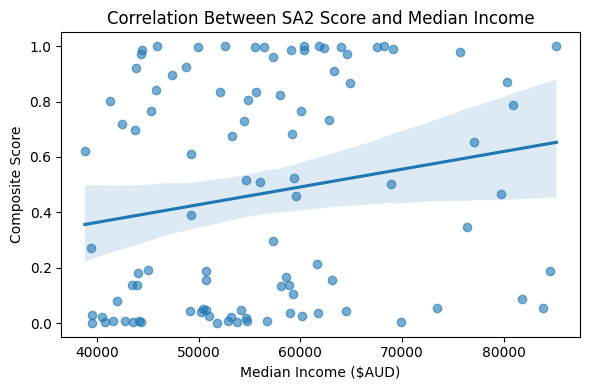

In [22]:
# Load median income dataset
sql=f"""
select i.sa2_code21, i.median_income
from income i
join sa2_regions s on s."SA2_CODE21"=i.sa2_code21
where s."SA4_CODE21" in ({area1}, {area2}, {area3})
"""
df_income = query(conn, sql)
# Merge with your score dataframe
df_corr = df_merged.merge(df_income, on="sa2_code21")

# Clean: drop rows with missing values
df_corr = df_corr.dropna(subset=["score", "median_income"])

df_corr["score"] = pd.to_numeric(df_corr["score"], errors='coerce')
df_corr["median_income"] = pd.to_numeric(df_corr["median_income"], errors='coerce')

df_corr = df_corr.dropna(subset=["score", "median_income"])

from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(df_corr["score"], df_corr["median_income"])
print(f"Pearson correlation coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value:.4f}")

plt.figure(figsize=(6, 4))
sns.regplot(x="median_income", y="score", data=df_corr, scatter_kws={"alpha":0.6})
plt.title("Correlation Between SA2 Score and Median Income")
plt.xlabel("Median Income ($AUD)")
plt.ylabel("Composite Score")
plt.tight_layout()
plt.savefig("correlation_plot.png", dpi=300)  # for LaTeX
plt.show()

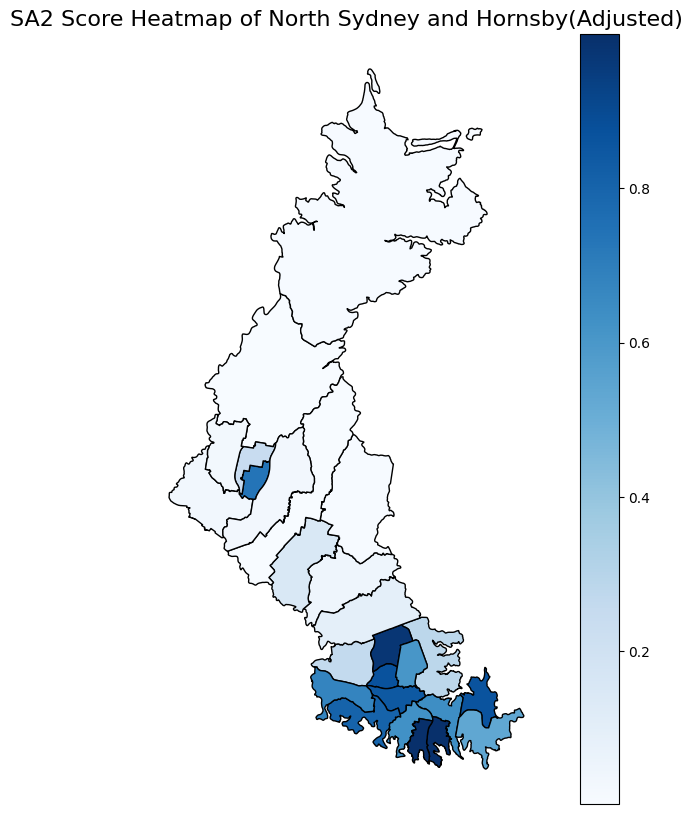

In [23]:
sql_stops = f"""
WITH valid_regions AS (
    SELECT sa2_code21
    FROM population
    WHERE total_people >= 100
),

stop_counts AS (
    SELECT
        r."SA2_CODE21" AS sa2_code21,
        COUNT(s.stop_id)/r."AREASQKM21" AS num_stops
    FROM sa2_regions r
    JOIN valid_regions vr ON r."SA2_CODE21" = vr.sa2_code21
    LEFT JOIN stops s ON r."SA2_CODE21" = s.sa2_code21
    WHERE r."SA4_CODE21" IN ({area1}, {area2}, {area3})
    GROUP BY r."SA2_CODE21"
),

stats AS (
    SELECT
        AVG(num_stops) AS mean_val,
        STDDEV_POP(num_stops) AS std_val
    FROM stop_counts
)

SELECT
    sc.sa2_code21,
    r."SA4_CODE21",
    sc.num_stops,
    (sc.num_stops - st.mean_val) / NULLIF(st.std_val, 0) AS z_score
FROM stop_counts sc
JOIN sa2_regions r ON sc.sa2_code21 = r."SA2_CODE21"
CROSS JOIN stats st
"""
df_stops=query(conn, sql_stops)

sql_poi=f"""
WITH filtered_poi AS (
  SELECT *
  FROM poi
  WHERE poigroup BETWEEN 1 AND 5
),


valid_regions AS (
  SELECT sa2_code21
  FROM population
  WHERE total_people >= 100
),

poi_counts AS (
  SELECT
    fp.sa2_code21,
    fp.poigroup,
    COUNT(*)/s."AREASQKM21" AS count
  FROM filtered_poi fp
  JOIN valid_regions vr ON fp.sa2_code21 = vr.sa2_code21
  join sa2_regions s on vr.sa2_code21=s."SA2_CODE21"
  GROUP BY fp.sa2_code21, fp.poigroup, s."AREASQKM21"
),

group_stats AS (
  SELECT
    poigroup,
    AVG(count) AS mean,
    STDDEV_POP(count) AS std
  FROM poi_counts
  GROUP BY poigroup
),

z_scores AS (
  SELECT
    pc.sa2_code21,
    pc.poigroup,
    (pc.count - gs.mean) / NULLIF(gs.std, 0) AS z_score
  FROM poi_counts pc
  JOIN group_stats gs ON pc.poigroup = gs.poigroup
),

total_z_scores AS (
  SELECT
    sa2_code21,
    SUM(z_score) AS total_z_score
  FROM z_scores
  GROUP BY sa2_code21
)

SELECT
  t.sa2_code21,
  r."SA2_NAME21",
  r."SA4_CODE21",
  t.total_z_score
FROM total_z_scores t
JOIN sa2_regions r ON t.sa2_code21 = r."SA2_CODE21"
ORDER BY t.total_z_score DESC
"""
df_poi=query(conn, sql_poi)

df_business = df_business.rename(columns={"z_score": "z_business"})
df_stops = df_stops.rename(columns={"z_score": "z_stops"})
df_schools = df_schools.rename(columns={"z_score": "z_schools"})
df_poi = df_poi.rename(columns={"total_z_score": "z_poi"})


df_merged = df_business.merge(df_stops, on=["sa2_code21", "SA4_CODE21"])
df_merged = df_merged.merge(df_schools, on=["sa2_code21", "SA4_CODE21"])
df_merged = df_merged.merge(df_poi, on=["sa2_code21", "SA4_CODE21"])

df_merged["score"] = 1 / (1 + np.exp(-(
    (df_merged["z_business"]
     + df_merged["z_stops"]
     + df_merged["z_schools"]
     + df_merged["z_poi"])
)))

sql_geom = f"""
SELECT *
FROM sa2_regions
WHERE "SA4_CODE21" IN ({area1})
"""
gdf_geom = query(conn, sql_geom, geom_name="geometry")
gdf = gdf_geom.merge(df_merged, left_on="SA2_CODE21", right_on="sa2_code21")

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column="score", cmap="Blues", legend=True, ax=ax, edgecolor='black')

plt.title("SA2 Score Heatmap of North Sydney and Hornsby(Adjusted)", fontsize=16)
plt.axis("off")
plt.show()

conn.commit()
conn.close()